# MMMI Oversight Script


**TODO**: Option for rolling macro updates
**TODO**: Volatility computation.
**TODO**: Distribution of agent wealth. (1st, second, third moment)
**TODO**: Fix steady state computation


**TODO**: Reduce NL logging/warning in the notebook.
**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.
**TODO**: `requirements.txt`
**TODO**: Begin automated tests
**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.
**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa
import itertools
import logging
import math
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Portfolio Consumption Model

The AttentionSimulation uses the Portfolio Consumption model from HARK.
The agent's resources unfold according to the following transition equations.

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

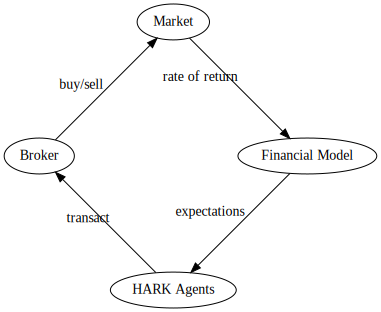

In [2]:
import graphviz as gv

dot = gv.Digraph(engine='circo')

dot.node('A', 'HARK Agents')
dot.node('B', 'Broker')
dot.node('M', 'Market')
dot.node('F', 'Financial Model')

dot.edge('A', 'B', label="transact")
dot.edge('B', 'M', label="buy/sell")
dot.edge('M', 'F', label="rate of return")
dot.edge('F', 'A', label="expectations")

dot

The AttentionSimulation class operates the "oversight code" with respect to four other simulation elements.

* HARK Agents - The consumers that earn, consume, and invest in the risky asset. When they have new targets for allocating their assets, they transact with the broker to buy or sell assets. They do this at the current 'market price'.
* Broker - Aggregates the consumer 
* Market - The PyNetLogo model of the Market, which takes the aggregate consumer demand and returns a rate of return.
* Financial Model - Computes the expectations of the risky asset from the rates of return history.

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [3]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 5, #3, 
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10
    }] * 20

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [4]:
class AttentionSimulation():
    """
    Encapsulates the "Oversight Code" functions of the experiment.
    Connects the Agent population model with a Broker, a Market simulation,
    and a FinanceModel of expected share prices.
    
    Parameters
    ----------
    
    agents: [HARK.AgentType]
    
    fm: hpa.FinanceModel
    
    q: int - number of quarters
    
    r: int - runs per quarter
    
    a: float - attention rate (between 0 and 1)
    
    """
    agents = None
    
    broker = None
    
    dollars_per_hark_money_unit = 1500
    
    # Number of days in a quarter / An empirical value based on trading calendars.
    days_per_quarter = 60
    
    # A FinanceModel
    fm = None
    
    # Simulation parameters
    quarters_per_simulation = None # Number of quarters to run total
    
    # Number of market runs to do per quarter
    # Valid values: 1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60...
    runs_per_quarter = None
    
    # For John's prefered condition: days per quarter = runs per quarter
    # Best if an integer.
    days_per_run = None
    
    ## upping this to make more agents engaged in trade
    attention_rate = None
    
    # for tracking history of the simulation
    history = {}
    
    # dividend_ror -> on financial model
    # dividend_std -> on financial model; on MarketPNL
    
    # sp500_ror = 0.000628 -> on financial model; on MarketPNL
    # sp500_std = 0.011988 -> on financial model; on MarketPNL
    
    def __init__(self, agents, fm, q = 1, r = None, a = None):
        
        self.agents = agents
        self.fm = fm
        
        self.quarters_per_simulation = q
        
        if r is not None:
            self.runs_per_quarter = r
        else:
            self.runs_per_quarter = self.days_per_quarter
        self.days_per_run = self.days_per_quarter / self.runs_per_quarter
        
        # TODO: Make this more variable.
        if a is not None:
            self.attention_rate = a
        else:
            self.attention_rate = 1 / self.runs_per_quarter 
        
        
        # Create the Market wrapper
        market = hpa.MarketPNL()
        self.broker = hpa.Broker(market)

        self.history = {}
        self.history['buy_sell'] = []
        self.history['owned_shares'] = []
        self.history['total_assets'] = []
    
    def attend(self, agent):
        """
        Cause the agent to attend to the financial model.
    
        This will update their expectations of the risky asset.
        They will then adjust their owned risky asset shares to meet their
        target.
    
        Return the delta of risky asset shares ordered through the brokers.
        
        NOTE: This MUTATES the agents with their new target share amounts.
        """
        # Note: this mutates the underlying agent
        agent.assign_parameters(**self.fm.risky_expectations())
            
        d_shares = self.compute_share_demand(agent)
            
        delta_shares = d_shares - agent.shares
            
        # NOTE: This mutates the agent
        agent.shares = d_shares
    
        return delta_shares
    
    def compute_share_demand(self, agent):
        """
        Computes the number of shares an agent _wants_ to own.
    
        This involves:
          - Computing a solution function based on their
            expectations and personal properties
          - Using the solution and the agent's current normalized
            assets to compute a share number
        """
        agent.assign_parameters(AdjustPrb = 1.0)
        agent.solve()
        asset_normalized = agent.state_now['aNrm']

        # ShareFunc takes normalized market assets as argument
        risky_share = agent.solution[0].ShareFuncAdj(
            asset_normalized
        )
    
        # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
        risky_asset_wealth = risky_share \
                            * asset_normalized \
                            * agent.state_now['pLvl'] \
                            * self.dollars_per_hark_money_unit 
        
        shares = risky_asset_wealth / self.fm.rap()
    
        if (np.isnan(shares)).any():
            print("ERROR: Agent has nan shares")
    
        return shares
    
    def data(self):
        """
        Returns a Pandas DataFrame of the data from the simulation run.
        """
        data = pd.DataFrame.from_dict({
            't' : range(len(self.fm.prices)),
            'prices' : self.fm.prices,
            'buy' : [None] + [bs[0] for bs in self.broker.buy_sell_history],
            'sell' : [None]  + [bs[1] for bs in self.broker.buy_sell_history],
            'owned' : self.history['owned_shares'],
            'total_assets' : self.history['total_assets'],
            'ror' : [None] + self.fm.ror_list,
            'expected_ror' : self.fm.expected_ror_list,
            'expected_std' : self.fm.expected_std_list,
        })

        return data

    
    def macro_update(self, agent):
        """
        Input: an agent, a FinancialModel, and a Broker
    
        Simulates one "macro" period for the agent (quarterly by assumption).
        For the purposes of the simulation, award the agent dividend income
        but not capital gains on the risky asset.
        """
    
        #agent.assign_parameters(AdjustPrb = 0.0)
        agent.solve()
        
        ## For risky asset gains in the simulated quarter,
        ## use only the dividend.
        true_risky_expectations = {
            "RiskyAvg" : agent.parameters['RiskyAvg'],
            "RiskyStd" : agent.parameters['RiskyStd']   
        }
        
        dividend_risky_params = {
            "RiskyAvg" : 1 + self.fm.dividend_ror,
            "RiskyStd" : self.fm.dividend_std
        }
        
        agent.assign_parameters(**dividend_risky_params)
        
        agent.simulate(sim_periods=1)
        
        ## put back the expectations that include capital gains now
        agent.assign_parameters(**true_risky_expectations)
    
        # Selling off shares if necessary to
        # finance this period's consumption
        asset_level_in_shares = agent.state_now['aLvl'] \
            * self.dollars_per_hark_money_unit / self.fm.rap()

        delta = asset_level_in_shares - agent.shares
        delta[delta > 0] = 0

        agent.shares = agent.shares + delta
        self.broker.transact(delta)

    def report(self):
        data = self.data()

        fig, ax = plt.subplots(
            4, 1,
            sharex='col',
            #sharey='col',
            figsize=(12,16),
        )

        ax[0].plot(data['total_assets'], alpha=0.5, label='total assets')
        ax[0].plot([p * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share value')
        ax[0].plot([100 * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share quantity * p_0')
        ax[0].legend()

        ax[1].plot(data['buy'], alpha=0.5, label='buy')
        ax[1].plot(data['sell'], alpha=0.5, label='sell')
        ax[1].legend()

        ax[2].plot(data['ror'], alpha=0.5, label='ror')
        ax[2].plot(data['expected_ror'], alpha=0.5, label='expected ror')
        ax[2].legend()

        ax[3].plot(data['prices'], alpha=0.5, label='prices')
        ax[3].legend()
    
        ax[0].set_title("Simulation History")
        ax[0].set_ylabel("Dollars")
        ax[1].set_xlabel("t")
        
        plt.show()

    def simulate(self):
        """
        Workhorse method that runs the simulation.
        """
        seeds = itertools.cycle([2,3,6,0,1,4,5])

        # Initialize share ownership for agents
        for agent in self.agents:
            agent.shares = self.compute_share_demand(agent)

        self.track()

        # Main loop
        for quarter in range(self.quarters_per_simulation):
            print(f"Q-{quarter}")
    
            for agent in self.agents:
                self.macro_update(agent)

            day = 0

            for run in range(self.runs_per_quarter):
                print(f"Q-{quarter}:R-{run}")
        
                # Set to a number for a fixed seed, or None to rotate
                seed = next(seeds)

                for agent in self.agents:
                    if random.random() < self.attention_rate:
                        self.broker.transact(self.attend(agent))

                buy_sell, ror = self.broker.trade(seed)
                print("ror: " + str(ror))
        
                new_run = True
        
                for new_day in range(int(self.days_per_run)):
                    if new_run:
                        new_run = False
                    else:
                        # sloppy
                        # problem is that this should really be nan, nan
                        # putting 0,0 here is a stopgap to make plotting code simpler
                        self.broker.buy_sell_history.append((0,0))
            
                    day = day + 1
                    print(f"Q-{quarter}:D-{day}")
        
                    self.update_agent_wealth_capital_gains(self.fm.rap(), ror)
        
                    self.track()

                    # combine these steps?
                    risky_asset_price = self.fm.add_ror(ror)
                    self.fm.calculate_risky_expectations()

    def track(self):
        """
        Tracks the current state of agent's total assets and owned shares
        """
        tal = sum(
                [agent.state_now['aLvl'].sum()
                 for agent
                 in self.agents]
                ) * self.dollars_per_hark_money_unit
        os = sum([sum(agent.shares) for agent in self.agents])

        self.history['owned_shares'].append(os)
        self.history['total_assets'].append(tal)
    
    
    def update_agent_wealth_capital_gains(self, old_share_price, ror):
        """
        For all agents,
        given the old share price
        and a rate of return
    
        update the agent's wealth level to adjust
        for the most recent round of capital gains.
        """

        new_share_price = old_share_price * (1 + ror)

        for agent in self.agents:
            old_raw = agent.shares * old_share_price
            new_raw = agent.shares * new_share_price
    
            delta_aNrm = (new_raw - old_raw) / \
                (self.dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
            # update normalized market assets
            # if agent.state_now['aNrm'] < delta_aNrm:
            #     breakpoint()
        
            agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_aNrm
        
            if (agent.state_now['aNrm'] < 0).any():
                print(f"ERROR: Agent with CRRA {agent.parameters['CRRA']} has negative aNrm after capital gains update.")
                print("Setting normalize assets and shares to 0.")
                agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0
                ## TODO: This change in shares needs to be registered with the Broker.
                agent.shares[(agent.state_now['aNrm'] == 0)] = 0

            # update non-normalized market assets
            agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

Accounting functions.

## Run the main loop



In [10]:
def run_simulation(i):
    # Initialize the financial model
    fm = hpa.FinanceModel()

    fm.calculate_risky_expectations()
    agent_parameters.update(fm.risky_expectations())

    # Initialize the population model
    agents = hpa.create_distributed_agents(agent_classes, agent_parameters)
    hpa.init_simulations(agents)


    attsim = AttentionSimulation(agents, fm, q = 6, r = 3)
    attsim.simulate()
    
    return attsim.data()

In [11]:
 run_simulation(0)

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Total Asset Levels: 635937.9704426232
Q-0
Q-0:R-0


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (960, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL960SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 

Elapsed (sys clock), run 2:  64.33922072600001
ror: 0.02799105073529412
Q-0:D-1
Total Asset Levels: 948084.391511258
Price end of day 1: 102.7991050735294

Q-0:D-2
Total Asset Levels: 969146.9308345205
Price end of day 2: 105.67656003918539

Q-0:D-3
Total Asset Levels: 990799.0327645919
Price end of day 3: 108.63455799277358

Q-0:D-4
Total Asset Levels: 1013057.1997783169
Price end of day 4: 111.67535341715555

Q-0:D-5
Total Asset Levels: 1035938.3962741964
Price end of day 5: 114.80126390053705

Q-0:D-6
Total Asset Levels: 1059460.0615020776
Price end of day 6: 118.01467190285287

Q-0:D-7
Total Asset Levels: 1083640.1228547292
Price end of day 7: 121.3180265715947

Q-0:D-8
Total Asset Levels: 1108497.009531487
Price end of day 8: 124.71384560846596

Q-0:D-9
Total Asset Levels: 1134049.6665843346
Price end of day 9: 128.20471718828617

Q-0:D-10
Total Asset Levels: 1160317.5693571686
Price end of day 10: 131.79330193160752

Q-0:D-11
Total Asset Levels: 1187320.7383292278
Price end of da

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (393, 0)


nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL393SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- T

Elapsed (sys clock), run 3:  43.400658023999995
ror: 0.02358369779411765
Q-0:D-21
Total Asset Levels: 1498628.3258565732
Price end of day 21: 177.79110869930815

Q-0:D-22
Total Asset Levels: 1530972.0093833103
Price end of day 22: 181.98408047735379

Q-0:D-23
Total Asset Levels: 1564078.4765678914
Price end of day 23: 186.2759380346721

Q-0:D-24
Total Asset Levels: 1597965.7166695814
Price end of day 24: 190.6690134635976

Q-0:D-25
Total Asset Levels: 1632652.1432009118
Price end of day 25: 195.16569385582565

Q-0:D-26
Total Asset Levels: 1668156.603933113
Price end of day 26: 199.76842259950075

Q-0:D-27
Total Asset Levels: 1704498.3911375655
Price end of day 27: 204.479700706895

Q-0:D-28
Total Asset Levels: 1741697.2520687461
Price end of day 28: 209.30208817339803

Q-0:D-29
Total Asset Levels: 1779773.3996944118
Price end of day 29: 214.23820536855723

Q-0:D-30
Total Asset Levels: 1818747.5236788467
Price end of day 30: 219.2907344599234

Q-0:D-31
Total Asset Levels: 1858640.801625

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (149, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL149SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 6:  37.95567316899999
ror: 0.0015469330882352942
Q-0:D-41
Total Asset Levels: 2266161.1278468263
Price end of day 41: 277.28424357663584

Q-0:D-42
Total Asset Levels: 2269534.112879568
Price end of day 42: 277.71318374787086

Q-0:D-43
Total Asset Levels: 2272912.3156944667
Price end of day 43: 278.14278746084966

Q-0:D-44
Total Asset Levels: 2276295.7443630844
Price end of day 44: 278.5730557420269

Q-0:D-45
Total Asset Levels: 2279684.4069694467
Price end of day 45: 279.00398961944506

Q-0:D-46
Total Asset Levels: 2283078.311610135
Price end of day 46: 279.4355901227371

Q-0:D-47
Total Asset Levels: 2286477.4663941944
Price end of day 47: 279.86785828312856

Q-0:D-48
Total Asset Levels: 2289881.8794432706
Price end of day 48: 280.3007951334403

Q-0:D-49
Total Asset Levels: 2293291.5588915385
Price end of day 49: 280.7344017080909

Q-0:D-50
Total Asset Levels: 2296706.5128857647
Price end of day 50: 281.16867904309913

Q-0:D-51
Total Asset Levels: 2300126.74958

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10


Buy/Sell Limit: (406, 2438)


logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model 

Elapsed (sys clock), run 0:  38.268595300000015
ror: -0.038119243382352945
Q-1:D-1
Total Asset Levels: 1837223.5962829473
Price end of day 1: 274.6636777234902

Q-1:D-2
Total Asset Levels: 1776160.2074631806
Price end of day 2: 264.1937061440563

Q-1:D-3
Total Asset Levels: 1717424.5088235866
Price end of day 3: 254.12284195946518

Q-1:D-4
Total Asset Levels: 1660927.7705756663
Price end of day 4: 244.4358714977971

Q-1:D-5
Total Asset Levels: 1606584.6452433304
Price end of day 5: 235.11816102079504

Q-1:D-6
Total Asset Levels: 1554313.0387316933
Price end of day 6: 226.1556346172321

Q-1:D-7
Total Asset Levels: 1504033.9863106604
Price end of day 7: 217.53475293896733

Q-1:D-8
Total Asset Levels: 1455671.5333259
Price end of day 8: 209.2424927475668

Q-1:D-9
Total Asset Levels: 1409152.62045703
Price end of day 9: 201.2663272405921

Q-1:D-10
Total Asset Levels: 1364406.9733496937
Price end of day 10: 193.59420712783566

Q-1:D-11
Total Asset Levels: 1321366.9964547423
Price end of day

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (604, 0)


nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL604SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 --

Elapsed (sys clock), run 1:  37.195434206000016
ror: 0.010361638970588236
Q-1:D-21
Total Asset Levels: 1009563.404940308
Price end of day 21: 132.61161676511423

Q-1:D-22
Total Asset Levels: 1018407.3900455912
Price end of day 22: 133.98569046134037

Q-1:D-23
Total Asset Levels: 1027343.0133315981
Price end of day 23: 135.37400181312577

Q-1:D-24
Total Asset Levels: 1036371.224320071
Price end of day 24: 136.77669834591714

Q-1:D-25
Total Asset Levels: 1045492.9823713576
Price end of day 25: 138.1939291137666

Q-1:D-26
Total Asset Levels: 1054709.256786349
Price end of day 26: 139.6258447151705

Q-1:D-27
Total Asset Levels: 1064021.0269094794
Price end of day 27: 141.0725973090725

Q-1:D-28
Total Asset Levels: 1073429.2822328052
Price end of day 28: 142.5343406310323

Q-1:D-29
Total Asset Levels: 1082935.0225011348
Price end of day 29: 144.01123000956193

Q-1:D-30
Total Asset Levels: 1092539.2578182719
Price end of day 30: 145.50342238263136

Q-1:D-31
Total Asset Levels: 1102243.008754

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (357, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL357SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 

Elapsed (sys clock), run 4:  38.87993057599999
ror: 0.019176344852941174
Q-1:D-41
Total Asset Levels: 1215243.6864649104
Price end of day 41: 164.39591846030228

Q-1:D-42
Total Asset Levels: 1236661.67735769
Price end of day 42: 167.54843128511303

Q-1:D-43
Total Asset Levels: 1258490.3870298907
Price end of day 43: 170.76139778300566

Q-1:D-44
Total Asset Levels: 1280737.6915664584
Price end of day 44: 174.03597723446285

Q-1:D-45
Total Asset Levels: 1303411.6180868687
Price end of day 45: 177.37335115072952

Q-1:D-46
Total Asset Levels: 1326520.3476414045
Price end of day 46: 180.77472370011773

Q-1:D-47
Total Asset Levels: 1350072.2181629913
Price end of day 47: 184.24132214248635

Q-1:D-48
Total Asset Levels: 1374075.7274756306
Price end of day 48: 187.7743972720525

Q-1:D-49
Total Asset Levels: 1398539.5363605304
Price end of day 49: 191.37522386869458

Q-1:D-50
Total Asset Levels: 1423472.4716810244
Price end of day 50: 195.04510115790947

Q-1:D-51
Total Asset Levels: 1448883.529

Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_


Buy/Sell Limit: (231, 2931)


lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model 

Elapsed (sys clock), run 5:  37.70447031899994
ror: -0.03371189044117648
Q-2:D-1
Total Asset Levels: 1059886.3031738964
Price end of day 1: 227.89512408704582

Q-2:D-2
Total Asset Levels: 1028436.1402645346
Price end of day 2: 220.212348631745

Q-2:D-3
Total Asset Levels: 998046.2218015334
Price end of day 3: 212.78857406087744

Q-2:D-4
Total Asset Levels: 968680.8049402715
Price end of day 4: 205.61506896500296

Q-2:D-5
Total Asset Levels: 940305.3517949958
Price end of day 5: 198.68339628699982

Q-2:D-6
Total Asset Levels: 912886.4888173735
Price end of day 6: 191.98540339889163

Q-2:D-7
Total Asset Levels: 886391.9675444737
Price end of day 7: 185.51321251320311

Q-2:D-8
Total Asset Levels: 860790.6266700176
Price end of day 8: 179.25921141756731

Q-2:D-9
Total Asset Levels: 836052.3553942684
Price end of day 9: 173.2160445216866

Q-2:D-10
Total Asset Levels: 812148.0580094702
Price end of day 10: 167.37660420611755

Q-2:D-11
Total Asset Levels: 789049.6196791825
Price end of day 11

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (332, 0)


pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL332SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 

Elapsed (sys clock), run 2:  32.88716199099997
ror: 0.02799105073529412
Q-2:D-21
Total Asset Levels: 627949.4274511962
Price end of day 21: 122.10977780193215

Q-2:D-22
Total Asset Levels: 643077.5691317398
Price end of day 22: 125.52775878766153

Q-2:D-23
Total Asset Levels: 658629.1633935948
Price end of day 23: 129.0414126525747

Q-2:D-24
Total Asset Levels: 674616.0631194478
Price end of day 24: 132.65341738108694

Q-2:D-25
Total Asset Levels: 691050.4529666264
Price end of day 25: 136.36652591721108

Q-2:D-26
Total Asset Levels: 707944.8586538221
Price end of day 26: 140.18356826275553

Q-2:D-27
Total Asset Levels: 725312.1565077502
Price end of day 27: 144.1074536342529

Q-2:D-28
Total Asset Levels: 743165.583277042
Price end of day 28: 148.1411726802633

Q-2:D-29
Total Asset Levels: 761518.7462208332
Price end of day 29: 152.28779976074253

Q-2:D-30
Total Asset Levels: 780385.6334797369
Price end of day 30: 156.55049529021179

Q-2:D-31
Total Asset Levels: 799780.6247371212
Price

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_


Buy/Sell Limit: (189, 0)


logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtrans

Elapsed (sys clock), run 3:  34.14168642200002
ror: 0.005954286029411765
Q-2:D-41
Total Asset Levels: 1006351.3105471049
Price end of day 41: 207.55157348824184

Q-2:D-42
Total Asset Levels: 1012055.0477549427
Price end of day 42: 208.7873949226453

Q-2:D-43
Total Asset Levels: 1017792.7466455529
Price end of day 43: 210.03057479135046

Q-2:D-44
Total Asset Levels: 1023564.6094365078
Price end of day 44: 211.2811569085799

Q-2:D-45
Total Asset Levels: 1029370.8395494431
Price end of day 45: 212.5391853494386

Q-2:D-46
Total Asset Levels: 1035211.6416172222
Price end of day 46: 213.80470445146733

Q-2:D-47
Total Asset Levels: 1041087.2214911545
Price end of day 47: 215.0777588162052

Q-2:D-48
Total Asset Levels: 1046997.7862482463
Price end of day 48: 216.35839331076173

Q-2:D-49
Total Asset Levels: 1052943.5441984949
Price end of day 49: 217.64665306939796

Q-2:D-50
Total Asset Levels: 1058924.704892243
Price end of day 50: 218.9425834951173

Q-2:D-51
Total Asset Levels: 1064941.479127

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (21, 1238)


nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL21SL1238.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 

Elapsed (sys clock), run 6:  33.488267078000035
ror: -0.029304537500000005
Q-3:D-1
Total Asset Levels: 779443.8235220467
Price end of day 1: 225.52551928674677

Q-3:D-2
Total Asset Levels: 756982.8685371153
Price end of day 2: 218.91659824960132

Q-3:D-3
Total Asset Levels: 735180.1214498254
Price end of day 3: 212.50134858682344

Q-3:D-4
Total Asset Levels: 714016.2937821579
Price end of day 4: 206.27409484836028

Q-3:D-5
Total Asset Levels: 693472.6622960212
Price end of day 5: 200.22932790059792

Q-3:D-6
Total Asset Levels: 673531.0524291564
Price end of day 6: 194.36170005253504

Q-3:D-7
Total Asset Levels: 654173.8222164448
Price end of day 7: 188.66602032478175

Q-3:D-8
Total Asset Levels: 635383.8466823988
Price end of day 8: 183.1372498571984

Q-3:D-9
Total Asset Levels: 617144.5026910125
Price end of day 9: 177.77049745111125

Q-3:D-10
Total Asset Levels: 599439.654239599
Price end of day 10: 172.5610152421615

Q-3:D-11
Total Asset Levels: 582253.6381835616
Price end of day 11

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_


Buy/Sell Limit: (48, 0)


logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtrans

Elapsed (sys clock), run 0:  33.647360573000014
ror: -0.007267772794117647
Q-3:D-21
Total Asset Levels: 445348.1491686064
Price end of day 21: 127.23447529718229

Q-3:D-22
Total Asset Levels: 442160.19687898585
Price end of day 22: 126.3097640391436

Q-3:D-23
Total Asset Levels: 438995.41390228394
Price end of day 23: 125.3917733724285

Q-3:D-24
Total Asset Levels: 435853.63184919977
Price end of day 24: 124.48045445330621

Q-3:D-25
Total Asset Levels: 432734.68355424574
Price end of day 25: 123.57575879303107

Q-3:D-26
Total Asset Levels: 429638.40306685644
Price end of day 26: 122.67763825526264

Q-3:D-27
Total Asset Levels: 426564.6256425559
Price end of day 27: 121.78604505350444

Q-3:D-28
Total Asset Levels: 423513.1877341951
Price end of day 28: 120.90093174856139

Q-3:D-29
Total Asset Levels: 420483.9269832479
Price end of day 29: 120.02225124601573

Q-3:D-30
Total Asset Levels: 417476.6822111724
Price end of day 30: 119.14995679372119

Q-3:D-31
Total Asset Levels: 414491.293410

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (149, 145)


nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL149SL145.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ti

Elapsed (sys clock), run 4:  33.51990518699995
ror: -0.007267772794117647
Q-4:D-1
Total Asset Levels: 326083.6118908141
Price end of day 1: 86.94442387184493

Q-4:D-2
Total Asset Levels: 323895.465678631
Price end of day 2: 86.31253155342891

Q-4:D-3
Total Asset Levels: 321723.2224159579
Price end of day 3: 85.68523168481349

Q-4:D-4
Total Asset Levels: 319566.76652377157
Price end of day 4: 85.06249088911693

Q-4:D-5
Total Asset Levels: 317425.9832630503
Price end of day 5: 84.44427603203313

Q-4:D-6
Total Asset Levels: 315300.75872866955
Price end of day 6: 83.83055422006856

Q-4:D-7
Total Asset Levels: 313190.9798433409
Price end of day 7: 83.22129279879215

Q-4:D-8
Total Asset Levels: 311096.5343515966
Price end of day 8: 82.61645935109779

Q-4:D-9
Total Asset Levels: 309017.3108138158
Price end of day 9: 82.01602169547955

Q-4:D-10
Total Asset Levels: 306953.1986002964
Price end of day 10: 81.41994788431938

Q-4:D-11
Total Asset Levels: 304904.0878853663
Price end of day 11: 80.82

Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv


Buy/Sell Limit: (96, 0)


logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 50

Elapsed (sys clock), run 5:  33.63140596599999
ror: 0.01476899191176471
Q-4:D-21
Total Asset Levels: 291098.11375633004
Price end of day 21: 76.81025640796187

Q-4:D-22
Total Asset Levels: 295135.5604883722
Price end of day 22: 77.94466646359163

Q-4:D-23
Total Asset Levels: 299232.6362385437
Price end of day 23: 79.09583061215761

Q-4:D-24
Total Asset Levels: 303390.221667332
Price end of day 24: 80.26399629472287

Q-4:D-25
Total Asset Levels: 307609.2104416901
Price end of day 25: 81.44941460680553

Q-4:D-26
Total Asset Levels: 311890.5094271325
Price end of day 26: 82.6523403523514

Q-4:D-27
Total Asset Levels: 316235.0388826629
Price end of day 27: 83.8730320985037

Q-4:D-28
Total Asset Levels: 320643.7326585823
Price end of day 28: 85.11175223118167

Q-4:D-29
Total Asset Levels: 325117.53839721985
Price end of day 29: 86.3687670114801

Q-4:D-30
Total Asset Levels: 329657.4177366261
Price end of day 30: 87.64434663290173

Q-4:D-31
Total Asset Levels: 334264.34651727625
Price end of

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (51, 0)


nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL51SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks

Elapsed (sys clock), run 2:  37.09429042099998
ror: 0.0015469330882352942
Q-4:D-41
Total Asset Levels: 379479.108256588
Price end of day 41: 101.64057055389013

Q-4:D-42
Total Asset Levels: 380046.84377716115
Price end of day 42: 101.79780171558707

Q-4:D-43
Total Asset Levels: 380615.45754659694
Price end of day 43: 101.95527610337054

Q-4:D-44
Total Asset Levels: 381184.9509234869
Price end of day 44: 102.11299409349502

Q-4:D-45
Total Asset Levels: 381755.32526852476
Price end of day 45: 102.27095606279703

Q-4:D-46
Total Asset Levels: 382326.58194451005
Price end of day 46: 102.42916238869603

Q-4:D-47
Total Asset Levels: 382898.7223163493
Price end of day 47: 102.58761344919535

Q-4:D-48
Total Asset Levels: 383471.7477510605
Price end of day 48: 102.746309622883

Q-4:D-49
Total Asset Levels: 384045.65961777704
Price end of day 49: 102.90525128893272

Q-4:D-50
Total Asset Levels: 384620.4592877506
Price end of day 50: 103.06443882710475

Q-4:D-51
Total Asset Levels: 385196.14813435

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv


Buy/Sell Limit: (38, 630)


logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 50

Elapsed (sys clock), run 3:  37.12929142799999
ror: -0.029304537500000005
Q-5:D-1
Total Asset Levels: 313129.1524659656
Price end of day 1: 101.60261751473051

Q-5:D-2
Total Asset Levels: 304141.1392216304
Price end of day 2: 98.62519979967193

Q-5:D-3
Total Asset Levels: 295416.5155484644
Price end of day 3: 95.73503393369745

Q-5:D-4
Total Asset Levels: 286947.56293690216
Price end of day 4: 92.92956304172364

Q-5:D-5
Total Asset Levels: 278726.78906473075
Price end of day 5: 90.20630517670882

Q-5:D-6
Total Asset Levels: 270746.92116877576
Price end of day 6: 87.5628511239215

Q-5:D-7
Total Asset Levels: 263000.89961082255
Price end of day 7: 84.99686226955363

Q-5:D-8
Total Asset Levels: 255481.87163209065
Price end of day 8: 82.50606853179316

Q-5:D-9
Total Asset Levels: 248183.18529072453
Price end of day 9: 80.08826635252565

Q-5:D-10
Total Asset Levels: 241098.38357694983
Price end of day 10: 77.74131674788806

Q-5:D-11
Total Asset Levels: 234221.19870067664
Price end of day 11

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (52, 0)


nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL52SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks

Elapsed (sys clock), run 6:  29.142267457000003
ror: -0.0028604198529411764
Q-5:D-21
Total Asset Levels: 180214.62523083802
Price end of day 21: 57.57551652943599

Q-5:D-22
Total Asset Levels: 179708.79617932267
Price end of day 22: 57.41082637891185

Q-5:D-23
Total Asset Levels: 179204.41401126832
Price end of day 23: 57.24660731136385

Q-5:D-24
Total Asset Levels: 178701.4745879811
Price end of day 24: 57.082857979296904

Q-5:D-25
Total Asset Levels: 178199.97378260497
Price end of day 25: 56.919577039070305

Q-5:D-26
Total Asset Levels: 177699.9074800888
Price end of day 26: 56.756763150886734

Q-5:D-27
Total Asset Levels: 177201.27157715228
Price end of day 27: 56.59441497878126

Q-5:D-28
Total Asset Levels: 176704.06198225182
Price end of day 28: 56.43253119061036

Q-5:D-29
Total Asset Levels: 176208.2746155478
Price end of day 29: 56.27111045804102

Q-5:D-30
Total Asset Levels: 175713.90540887
Price end of day 30: 56.110151456539796

Q-5:D-31
Total Asset Levels: 175220.9503056861

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (20, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL20SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5

Elapsed (sys clock), run 0:  32.988057432999994
ror: 0.0015469330882352942
Q-5:D-41
Total Asset Levels: 171108.1251043985
Price end of day 41: 54.61001550786643

Q-5:D-42
Total Asset Levels: 171369.32822470053
Price end of day 42: 54.6944935478046

Q-5:D-43
Total Asset Levels: 171630.93540875212
Price end of day 43: 54.77910226961797

Q-5:D-44
Total Asset Levels: 171892.9472816127
Price end of day 44: 54.863841875462676

Q-5:D-45
Total Asset Levels: 172155.36446930893
Price end of day 45: 54.94871256780754

Q-5:D-46
Total Asset Levels: 172418.1875988357
Price end of day 46: 55.03371454943462

Q-5:D-47
Total Asset Levels: 172681.41729815808
Price end of day 47: 55.11884802343964

Q-5:D-48
Total Asset Levels: 172945.0541962119
Price end of day 48: 55.204113193232516

Q-5:D-49
Total Asset Levels: 173209.09892290676
Price end of day 49: 55.28951026253782

Q-5:D-50
Total Asset Levels: 173473.5521091262
Price end of day 50: 55.375039435395266

Q-5:D-51
Total Asset Levels: 173738.4143867295
P

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,6359.379704,6.359380e+05,NaN,0.000628,0.011988
1,1,102.799105,960.0,0.0,7319.850206,9.480844e+05,0.027991,0.001658,0.012822
2,2,105.676560,0.0,0.0,7319.850206,9.691469e+05,0.027991,0.002650,0.013437
3,3,108.634558,0.0,0.0,7319.850206,9.907990e+05,0.027991,0.003604,0.013884
4,4,111.675353,0.0,0.0,7319.850206,1.013057e+06,0.027991,0.004522,0.014200
...,...,...,...,...,...,...,...,...,...
356,356,55.891000,0.0,0.0,3091.964734,1.750689e+05,0.001547,-0.000969,0.006761
357,357,55.977460,0.0,0.0,3091.964734,1.753362e+05,0.001547,-0.000783,0.006540
358,358,56.064053,0.0,0.0,3091.964734,1.756040e+05,0.001547,-0.000611,0.006323
359,359,56.150780,0.0,0.0,3091.964734,1.758721e+05,0.001547,-0.000451,0.006111


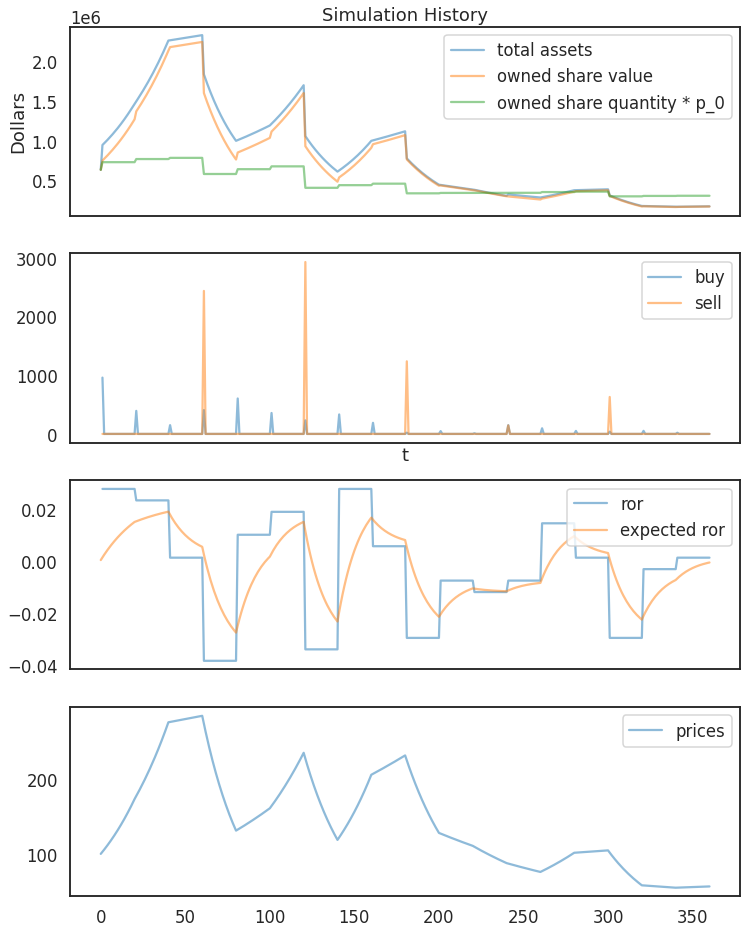

In [14]:
report(_11)

In [7]:
import multiprocessing

inputs = range(3)

pool = multiprocessing.Pool()
records = pool.map(run_simulation, inputs)
pool.close()

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Total Asset Levels: 635937.9704426232
Q-0
Total Asset Levels: 635937.9704426232
Q-0
Total Asset Levels: 635937.9704426232
Q-0
Q-0:R-0
Q-0:R-0
Q-0:R-0
Buy/Sell Limit: (2916, 0)
Output for S:2,BL:2916,SL:0 already exists.
Will use cache.
ror: 0.02799105073529412
Q-0:D-1
Total Asset Levels: 953559.7304921295
Price end of day 1: 102.7991050735294

Q-0:D-2
Total Asset Levels: 980250.8692874662
Price end of day 2: 105.67656003918539

Q-0:D-3
Total Asset Levels: 1007689.1211030066
Price end of day 3: 108.63455799277358

Q-0:D-4
Total Asset Levels: 1035895.3984172045
Price end of day 4: 111.67535341715555

Q-0:D-5
Total Asset Levels: 1064891.1990707582
Price end of day 5: 114.80126390053705

Q-0:D-6
Total Asset Levels: 1094698.6

Total Asset Levels: 3791530.8727234094
Price end of day 51: 408.7483647966833Price end of day 22: 183.55463078774864Total Asset Levels: 1365240.7501316164

Price end of day 14: 147.1806357122616




Q-0:D-15Q-0:D-52Q-0:D-23


Total Asset Levels: 1750303.0426454782Total Asset Levels: 1403455.2732344433Total Asset Levels: 3897659.805746225


Price end of day 15: 151.30037635373634Price end of day 23: 188.69251777082667Price end of day 52: 420.18966101367573




Q-0:D-16Q-0:D-24

Q-0:D-53

Total Asset Levels: 1442739.460992268
Total Asset Levels: 4006759.399117793Total Asset Levels: 1799295.8639143093Price end of day 16: 155.53543286452285


Price end of day 53: 431.95121113355555

Price end of day 24: 193.97421960912027
Q-0:D-54
Q-0:D-17

Total Asset Levels: 1483123.2544427072
Total Asset Levels: 4118912.8047426064Q-0:D-25


Price end of day 17: 159.88903305696962
Price end of day 54: 444.0419793995666
Q-0:D-18Total Asset Levels: 1849660.0457289396


Price end of day 25: 199.403761831538

Price end of day 58: 495.88544981499905

Q-0:D-59
Total Asset Levels: 4728563.958805579
Price end of day 59: 509.7658045996648

Q-0:D-60
Total Asset Levels: 4860921.432481581
Price end of day 60: 524.034685099332



In [8]:
records

[     t      prices     buy  sell        owned  total_assets       ror  \
 0    0  100.000000     NaN   NaN  6359.379704  6.359380e+05       NaN   
 1    1  102.799105  2916.0   0.0  9275.953617  9.535597e+05  0.027991   
 2    2  105.676560     0.0   0.0  9275.953617  9.802509e+05  0.027991   
 3    3  108.634558     0.0   0.0  9275.953617  1.007689e+06  0.027991   
 4    4  111.675353     0.0   0.0  9275.953617  1.035895e+06  0.027991   
 ..  ..         ...     ...   ...          ...           ...       ...   
 56  56  469.248289     0.0   0.0  9275.953617  4.352725e+06  0.027991   
 57  57  482.383042     0.0   0.0  9275.953617  4.474563e+06  0.027991   
 58  58  495.885450     0.0   0.0  9275.953617  4.599810e+06  0.027991   
 59  59  509.765805     0.0   0.0  9275.953617  4.728564e+06  0.027991   
 60  60  524.034685     0.0   0.0  9275.953617  4.860921e+06  0.027991   
 
     expected_ror  expected_std  
 0       0.000628      0.011988  
 1       0.001658      0.012822  
 2      

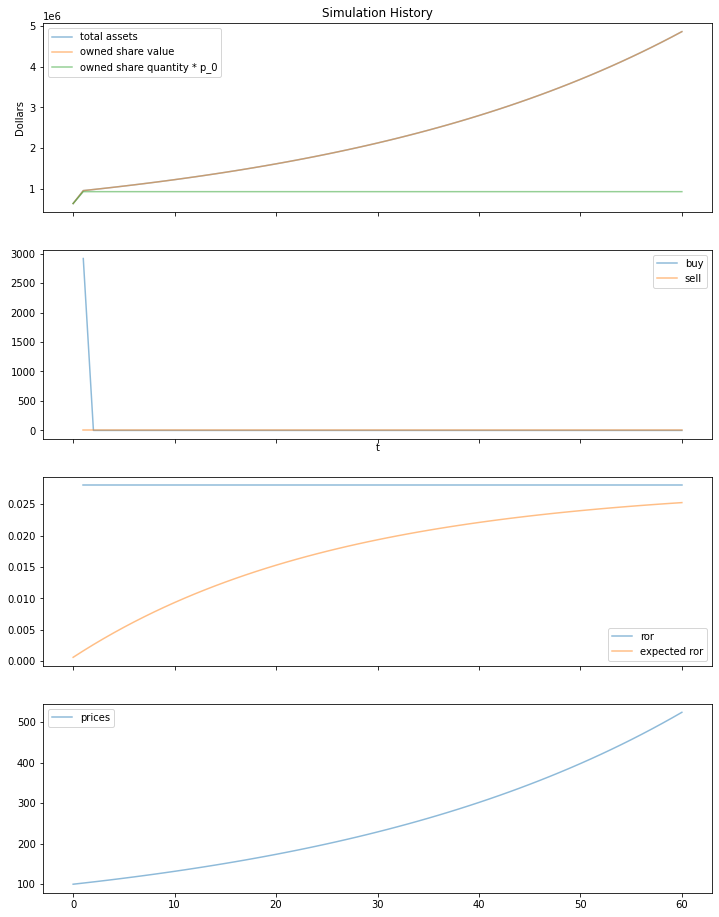

In [9]:
def report(data):
    fig, ax = plt.subplots(
        4, 1,
        sharex='col',
        #sharey='col',
        figsize=(12,16),
    )

    ax[0].plot(data['total_assets'], alpha=0.5, label='total assets')
    ax[0].plot([p * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share value')
    ax[0].plot([100 * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share quantity * p_0')
    ax[0].legend()

    ax[1].plot(data['buy'], alpha=0.5, label='buy')
    ax[1].plot(data['sell'], alpha=0.5, label='sell')
    ax[1].legend()

    ax[2].plot(data['ror'], alpha=0.5, label='ror')
    ax[2].plot(data['expected_ror'], alpha=0.5, label='expected ror')
    ax[2].legend()

    ax[3].plot(data['prices'], alpha=0.5, label='prices')
    ax[3].legend()
    
    ax[0].set_title("Simulation History")
    ax[0].set_ylabel("Dollars")
    ax[1].set_xlabel("t")
        
    plt.show()
    
report(records[1])